In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from cvxpy import Variable, Minimize, quad_form, Problem
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import datetime
import os

In [3]:
# load and prep price data for performance metric calcs later
price_data = pd.read_csv('/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/price_data.csv', index_col='Date')
price_data.index = pd.to_datetime(price_data.index)
price_data = price_data.resample('M').last()

In [4]:
rets = price_data.pct_change().dropna()
rets

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-31,-0.070368,-0.090541,-0.057413,-0.125355,-0.056942,-0.097036,-0.100547,-0.071719,-0.066387,-0.151764,...,-0.013898,-0.089586,-0.168687,-0.097114,-0.054851,-0.038230,-0.139381,-0.051944,-0.059737,-0.101806
2010-06-30,-0.016400,0.021765,-0.006947,-0.036795,-0.074702,0.033676,-0.054708,-0.002950,-0.046579,-0.119188,...,-0.097090,0.090547,0.012230,-0.094462,-0.033327,-0.098295,-0.098438,-0.049248,-0.072681,-0.056070
2010-07-31,0.058910,0.059644,0.025086,0.152801,0.098463,0.139040,0.119889,0.072486,0.017451,0.166957,...,-0.000578,0.020093,0.090619,0.148456,0.084005,0.043726,0.086505,0.064905,0.000426,0.045733
2010-08-31,0.005297,0.131748,-0.064453,-0.033775,-0.080926,-0.060900,0.019978,-0.012613,-0.008866,-0.040466,...,0.023073,-0.041485,-0.091425,-0.075491,-0.112367,0.001800,-0.092059,-0.014795,-0.074848,-0.002464
2010-09-30,0.058776,0.036027,0.097986,0.094392,0.171619,0.127361,0.125302,0.033569,0.092393,0.109930,...,0.067633,0.035055,0.195660,0.149718,0.046320,0.044566,0.149569,0.067411,0.020524,0.045339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.075721,-0.061648,0.029726,0.036675,-0.063925,-0.001790,-0.032227,-0.041245,0.002979,-0.085499,...,-0.015105,-0.030683,-0.006943,-0.049260,-0.087276,-0.064741,-0.089486,0.020819,0.105586,0.045333
2023-09-30,-0.058795,-0.048928,-0.050376,0.029234,-0.142422,-0.087862,-0.035028,-0.086417,-0.071693,-0.069273,...,-0.061350,-0.152052,-0.065113,-0.106765,-0.051687,-0.126274,-0.055008,-0.016481,-0.077882,0.057469
2023-10-31,-0.018344,-0.051047,-0.092942,0.017720,-0.254411,0.059894,-0.003387,0.016331,-0.022241,-0.072823,...,-0.066026,-0.073794,-0.044060,0.017588,0.014465,0.001990,-0.137027,0.021760,-0.151702,-0.099762


In [5]:
rets = np.log(price_data).diff().dropna()
rets

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-31,-0.072966,-0.094906,-0.059127,-0.133938,-0.058628,-0.102073,-0.105968,-0.074420,-0.068694,-0.164596,...,-0.013996,-0.093855,-0.184749,-0.102159,-0.056413,-0.038980,-0.150103,-0.053341,-0.061596,-0.107369
2010-06-30,-0.016536,0.021531,-0.006971,-0.037489,-0.077639,0.033121,-0.056261,-0.002955,-0.047699,-0.126911,...,-0.102132,0.086679,0.012156,-0.099226,-0.033895,-0.103467,-0.103627,-0.050502,-0.075458,-0.057703
2010-07-31,0.057240,0.057933,0.024777,0.142195,0.093912,0.130186,0.113229,0.069979,0.017300,0.154400,...,-0.000578,0.019894,0.086745,0.138418,0.080663,0.042797,0.082966,0.062886,0.000426,0.044718
2010-08-31,0.005283,0.123763,-0.066624,-0.034358,-0.084388,-0.062833,0.019781,-0.012693,-0.008906,-0.041307,...,0.022811,-0.042370,-0.095877,-0.078492,-0.119197,0.001798,-0.096576,-0.014906,-0.077798,-0.002467
2010-09-30,0.057113,0.035393,0.093478,0.090199,0.158387,0.119880,0.118052,0.033018,0.088371,0.104297,...,0.065444,0.034454,0.178699,0.139517,0.045279,0.043602,0.139387,0.065236,0.020316,0.044342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.078741,-0.063630,0.029293,0.036018,-0.066060,-0.001791,-0.032758,-0.042120,0.002975,-0.089377,...,-0.015221,-0.031164,-0.006967,-0.050514,-0.091321,-0.066932,-0.093746,0.020605,0.100376,0.044335
2023-09-30,-0.060594,-0.050166,-0.051689,0.028815,-0.153643,-0.091964,-0.035657,-0.090381,-0.074393,-0.071789,...,-0.063313,-0.164936,-0.067329,-0.112905,-0.053071,-0.134989,-0.056579,-0.016618,-0.081082,0.055879
2023-10-31,-0.018514,-0.052396,-0.097549,0.017565,-0.293580,0.058169,-0.003393,0.016200,-0.022492,-0.075611,...,-0.068307,-0.076659,-0.045060,0.017435,0.014362,0.001988,-0.147372,0.021526,-0.164523,-0.105096


In [6]:
test_rets = rets.iloc[-6:]
test_rets

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-31,0.025752,0.117254,0.117768,0.035743,-0.049669,0.002017,0.019178,0.045124,0.053862,0.090500,...,0.040521,0.019979,-0.016043,0.057638,0.034794,0.034061,0.095619,0.016907,-0.037953,-0.000093
2023-08-31,-0.078741,-0.063630,0.029293,0.036018,-0.066060,-0.001791,-0.032758,-0.042120,0.002975,-0.089377,...,-0.015221,-0.031164,-0.006967,-0.050514,-0.091321,-0.066932,-0.093746,0.020605,0.100376,0.044335
2023-09-30,-0.060594,-0.050166,-0.051689,0.028815,-0.153643,-0.091964,-0.035657,-0.090381,-0.074393,-0.071789,...,-0.063313,-0.164936,-0.067329,-0.112905,-0.053071,-0.134989,-0.056579,-0.016618,-0.081082,0.055879
2023-10-31,-0.018514,-0.052396,-0.097549,0.017565,-0.293580,0.058169,-0.003393,0.016200,-0.022492,-0.075611,...,-0.068307,-0.076659,-0.045060,0.017435,0.014362,0.001988,-0.147372,0.021526,-0.164523,-0.105096
2023-11-30,0.098047,0.035914,0.052228,0.062394,-0.044434,0.077216,-0.043009,0.062698,-0.067925,0.084522,...,0.159629,-0.027253,0.176487,0.075416,0.081973,0.199089,0.101119,-0.048396,0.097740,-0.020719
2023-12-31,0.053941,-0.020693,0.019222,-0.002542,0.177982,0.089794,0.018343,0.018197,0.035955,0.183329,...,0.112188,0.141270,0.057679,0.076227,0.013214,0.062360,0.084678,0.016218,0.003870,-0.027231


In [7]:
test_cum_rets = (1 + test_rets).cumprod() - 1

In [8]:
test_cum_rets['CTAS']

Date
2023-07-31    0.009929
2023-08-31    0.016991
2023-09-30   -0.030834
2023-10-31    0.020396
2023-11-30    0.111806
2023-12-31    0.206914
Freq: M, Name: CTAS, dtype: float64

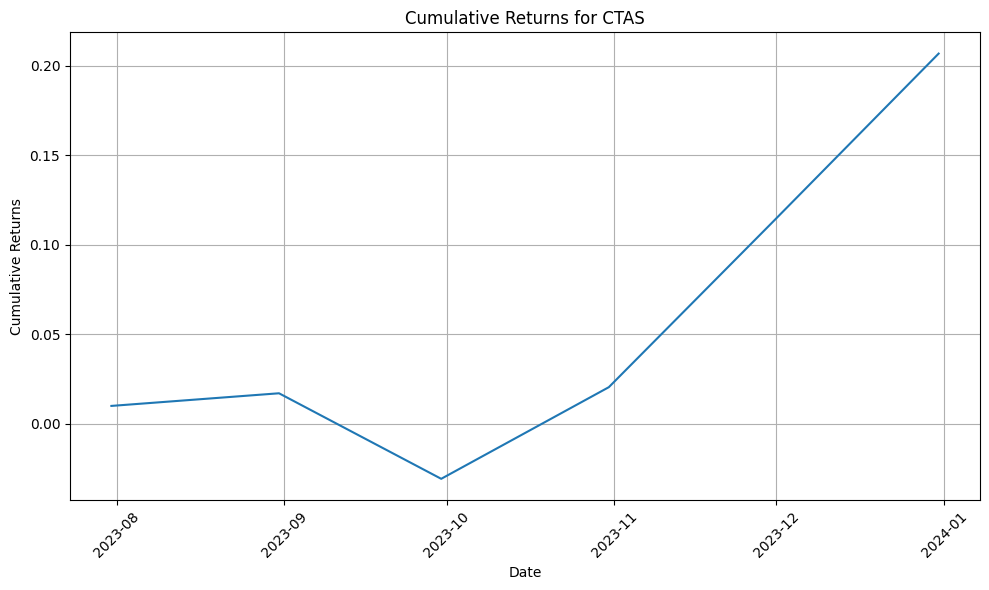

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(test_cum_rets['CTAS'])
plt.title(f"Cumulative Returns for CTAS")
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
top_bottom_performers = pd.DataFrame(columns=['Date', 'Top_5', 'Top_5_ret', 'Bottom_5', 'Bottom_5_ret'])
# Iterate through each date
for date in test_rets.index:
    # Sort stocks based on returns for the current date
    sorted_stocks = test_rets.loc[date].sort_values()

    # Get top 5 performing stocks
    top_5 = sorted_stocks.tail(5)
    # Get bottom 5 performing stocks
    bottom_5 = sorted_stocks.head(5)

    new_df = pd.DataFrame({
        'Date': date,
        'Top_5': top_5.index.tolist(),
        'Top_5_ret': top_5.values,
        'Bottom_5': bottom_5.index.tolist(),
        'Bottom_5_ret': bottom_5.values
    })

    top_bottom_performers = pd.concat([top_bottom_performers, new_df], axis=0)

In [11]:
top_bottom_performers

,Date,Top_5,Top_5_ret,Bottom_5,Bottom_5_ret
0,2023-07-31,BEN,0.090500,GPC,-0.083199
1,2023-07-31,TROW,0.095619,KMB,-0.067101
2,2023-07-31,CINF,0.100230,GWW,-0.065639
3,2023-07-31,ADM,0.117254,ALB,-0.049669
4,2023-07-31,ADP,0.117768,CLX,-0.048702
0,2023-08-31,XOM,0.044335,CHRW,-0.095925
1,2023-08-31,BRO,0.052130,TROW,-0.093746
2,2023-08-31,CAT,0.058446,SYY,-0.091321
3,2023-08-31,EMR,0.078246,BEN,-0.089377
4,2023-08-31,WST,0.100376,EXPD,-0.086854


In [12]:
top_bottom_performers.dtypes

Date            datetime64[ns]
Top_5                   object
Top_5_ret              float64
Bottom_5                object
Bottom_5_ret           float64
dtype: object

In [13]:
rnn_test_wts = pd.read_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/20240517_203713/RNN_test_wts.csv")
rnn_test_wts['Date'] = pd.to_datetime(rnn_test_wts['Date'])

In [14]:
rnn_test_wts

,Date,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
0,2023-07-31,0.000426,0.000267,0.168690,0.001036,0.000455,0.001092,0.000446,0.004356,0.001881,...,0.000158,0.000546,0.040058,0.000291,0.344036,0.003522,0.002823,0.000547,0.000837,0.002102
1,2023-08-31,0.000426,0.000267,0.168690,0.001036,0.000455,0.001092,0.000446,0.004356,0.001881,...,0.000158,0.000546,0.040058,0.000291,0.344036,0.003522,0.002823,0.000547,0.000837,0.002102
2,2023-09-30,0.000690,0.001503,0.024040,0.001435,0.034671,0.019877,0.001240,0.000529,0.017974,...,0.002906,0.036314,0.001436,0.001009,0.004479,0.000312,0.000692,0.004488,0.014260,0.157477
3,2023-10-31,0.000690,0.001503,0.024040,0.001435,0.034671,0.019877,0.001240,0.000529,0.017974,...,0.002906,0.036314,0.001436,0.001009,0.004479,0.000312,0.000692,0.004488,0.014260,0.157477
4,2023-11-30,0.000690,0.001503,0.024040,0.001435,0.034671,0.019877,0.001240,0.000529,0.017974,...,0.002906,0.036314,0.001436,0.001009,0.004479,0.000312,0.000692,0.004488,0.014260,0.157477
5,2023-12-31,0.000131,0.000428,0.028532,0.000062,0.000036,0.000067,0.000468,0.000578,0.000344,...,0.002815,0.000195,0.280264,0.000009,0.056287,0.008738,0.008910,0.000752,0.000014,0.000091


In [15]:
master_df = pd.DataFrame()
for idx, u_date in enumerate(sorted(rnn_test_wts.Date.unique())):
  print(u_date)
  # filter on date
  ftb = top_bottom_performers[top_bottom_performers.Date==u_date]
  dated_rnn = rnn_test_wts[rnn_test_wts.Date==u_date]

  # get top 5 performers and their associated weights
  top_5_tickers = ftb.Top_5.values
  top5_df = ftb[['Top_5', 'Top_5_ret']]
  rnn_top_5_wts = dated_rnn[top_5_tickers]
  rnn_top_wts = rnn_top_5_wts.T.reset_index().rename(columns={'index': 'Top_5', idx: 'Top5_RNN_wts'})
  top_5 = top5_df.merge(rnn_top_wts, on='Top_5')


  # get bottom 5 performers and their associated weights
  bot_5_tickers = ftb.Bottom_5.values
  bot5_df = ftb[['Bottom_5', 'Bottom_5_ret']]
  rnn_bot_5_wts = dated_rnn[bot_5_tickers]
  rnn_bot_wts = rnn_bot_5_wts.T.reset_index().rename(columns={'index': 'Bottom_5', idx:'Bot5_RNN_wts'})
  bot_5 = bot5_df.merge(rnn_bot_wts, on='Bottom_5')

  date_df = pd.concat([top_5, bot_5], axis=1)
  date_df.insert(0, 'Date', u_date)
  # date_df.index = [u_date]*5

  master_df = pd.concat([master_df, date_df], axis=0)

master_df.set_index('Date', inplace=True)

2023-07-31 00:00:00
2023-08-31 00:00:00
2023-09-30 00:00:00
2023-10-31 00:00:00
2023-11-30 00:00:00
2023-12-31 00:00:00


In [ ]:
master_df.to_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/20240517/top5_bot5_RNNanalysis.csv")

In [ ]:
rnn_top_5_wts.T.reset_index().rename(columns={'index': 'Top_5', 0: 'RNN_wts'})

,Top_5,RNN_wts
0,BEN,0.000728
1,TROW,0.002823
2,CINF,0.000544
3,ADM,0.000267
4,ADP,0.168690


In [16]:
master_df

,Top_5,Top_5_ret,Top5_RNN_wts,Bottom_5,Bottom_5_ret,Bot5_RNN_wts
Date,,,,,,
2023-07-31,BEN,0.090500,0.000728,GPC,-0.083199,0.000127
2023-07-31,TROW,0.095619,0.002823,KMB,-0.067101,0.000549
2023-07-31,CINF,0.100230,0.000544,GWW,-0.065639,0.000588
2023-07-31,ADM,0.117254,0.000267,ALB,-0.049669,0.000455
2023-07-31,ADP,0.117768,0.168690,CLX,-0.048702,0.003209
2023-08-31,XOM,0.044335,0.002102,CHRW,-0.095925,0.000267
2023-08-31,BRO,0.052130,0.014471,TROW,-0.093746,0.002823
2023-08-31,CAT,0.058446,0.022079,SYY,-0.091321,0.344036
2023-08-31,EMR,0.078246,0.001756,BEN,-0.089377,0.000728


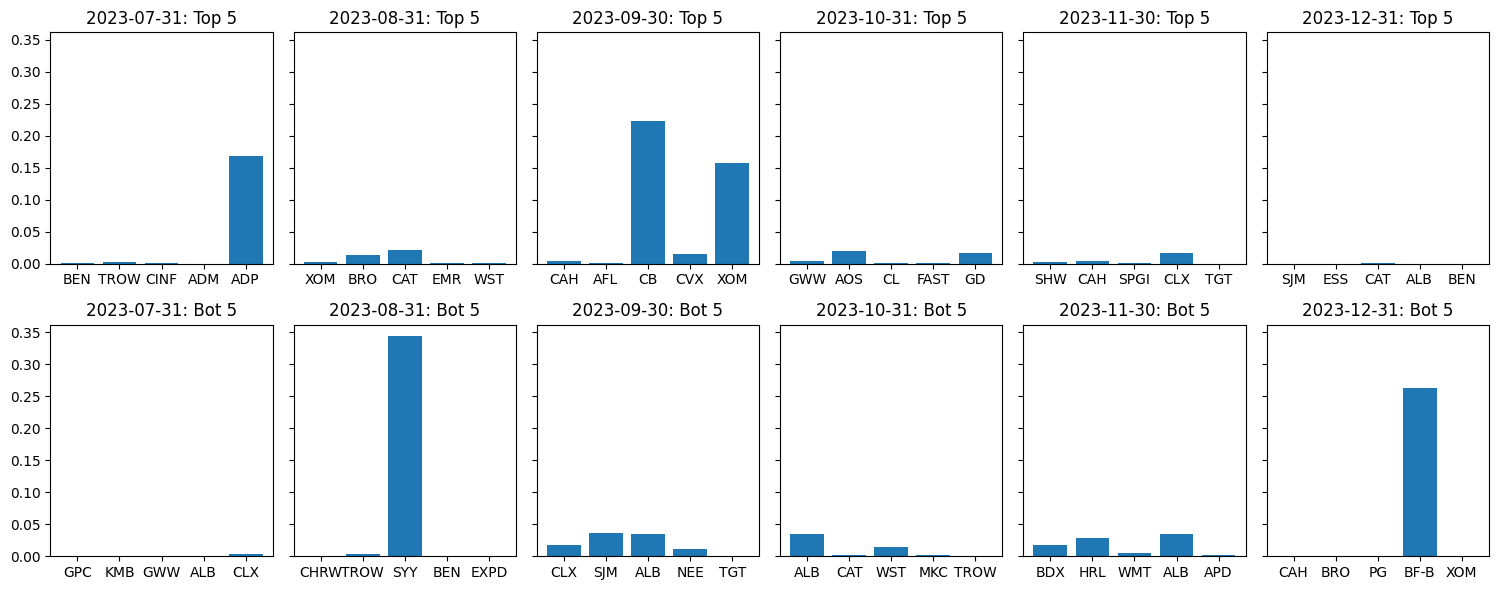

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a 2x5 grid of subplots
rows = 2
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(15, 6), sharey=True)

# Plotting each bar plot
for i, date in enumerate(master_df.index.unique()):
  date_str = date.strftime('%Y-%m-%d')
  f_df = master_df[master_df.index==date]

  ax = axes[0, i]
  ax.bar(f_df['Top_5'], f_df['Top5_RNN_wts'])
  ax.set_title(f'{date_str}: Top 5')

  ax = axes[1, i]
  ax.bar(f_df['Bottom_5'], f_df['Bot5_RNN_wts'])
  ax.set_title(f'{date_str}: Bot 5')

# Adjusting layout
plt.tight_layout()
plt.show()

### Let's look at test rets distribution at each time period

In [30]:
test_rets

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-31,0.025752,0.117254,0.117768,0.035743,-0.049669,0.002017,0.019178,0.045124,0.053862,0.090500,...,0.040521,0.019979,-0.016043,0.057638,0.034794,0.034061,0.095619,0.016907,-0.037953,-0.000093
2023-08-31,-0.078741,-0.063630,0.029293,0.036018,-0.066060,-0.001791,-0.032758,-0.042120,0.002975,-0.089377,...,-0.015221,-0.031164,-0.006967,-0.050514,-0.091321,-0.066932,-0.093746,0.020605,0.100376,0.044335
2023-09-30,-0.060594,-0.050166,-0.051689,0.028815,-0.153643,-0.091964,-0.035657,-0.090381,-0.074393,-0.071789,...,-0.063313,-0.164936,-0.067329,-0.112905,-0.053071,-0.134989,-0.056579,-0.016618,-0.081082,0.055879
2023-10-31,-0.018514,-0.052396,-0.097549,0.017565,-0.293580,0.058169,-0.003393,0.016200,-0.022492,-0.075611,...,-0.068307,-0.076659,-0.045060,0.017435,0.014362,0.001988,-0.147372,0.021526,-0.164523,-0.105096
2023-11-30,0.098047,0.035914,0.052228,0.062394,-0.044434,0.077216,-0.043009,0.062698,-0.067925,0.084522,...,0.159629,-0.027253,0.176487,0.075416,0.081973,0.199089,0.101119,-0.048396,0.097740,-0.020719
2023-12-31,0.053941,-0.020693,0.019222,-0.002542,0.177982,0.089794,0.018343,0.018197,0.035955,0.183329,...,0.112188,0.141270,0.057679,0.076227,0.013214,0.062360,0.084678,0.016218,0.003870,-0.027231


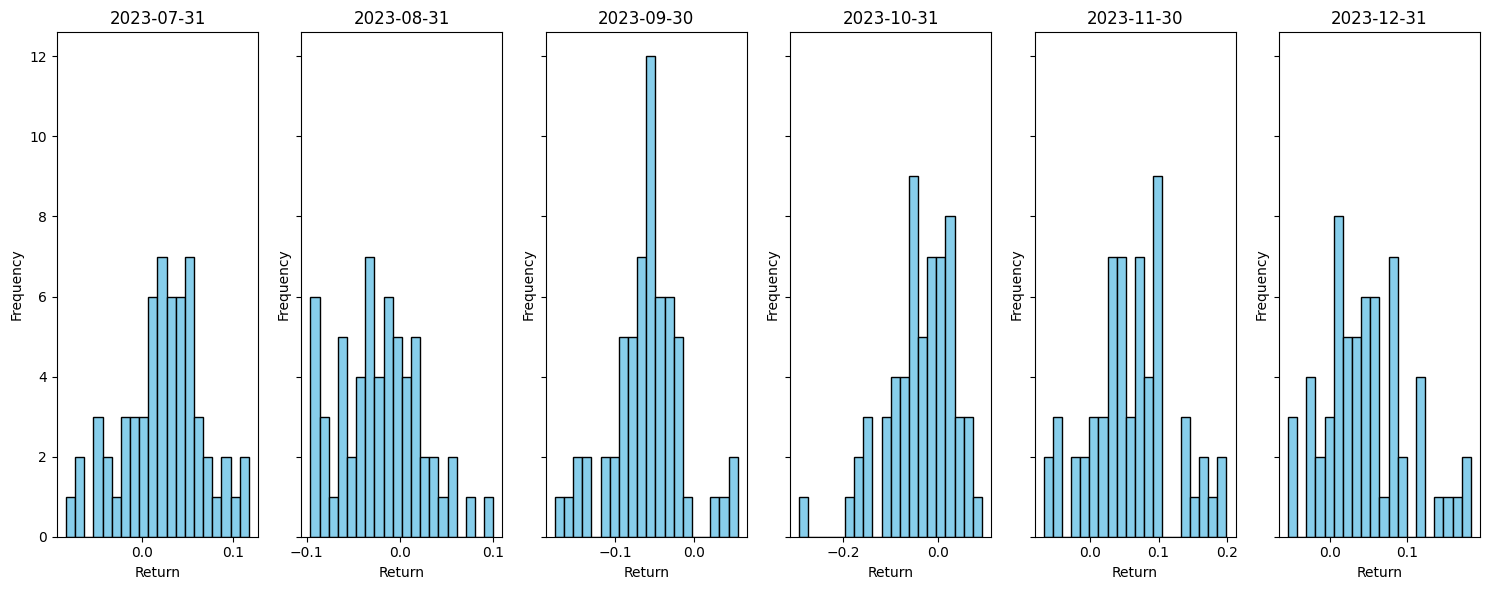

In [32]:
# Creating a 2x5 grid of subplots
rows = 1
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(15, 6), sharey=True)

# Plotting each bar plot
for i, date in enumerate(master_df.index.unique()):
  date_str = date.strftime('%Y-%m-%d')
  rets = test_rets.loc[date]

  ax = axes[i]
  ax.hist(rets, bins=20, color='skyblue', edgecolor='black')
  ax.set_title(f'{date_str}')
  ax.set_xlabel('Return')
  ax.set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()
plt.show()